In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import xgboost
import graphviz

RANDOM_SEED = 1212

## Data Loading

In [3]:
train = pd.read_csv('../data/small/train/orange_small_train.data', sep="\t")
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [4]:
churn_label = (
    pd.read_csv(
        "../data/small/labels/orange_small_train_churn.labels", sep="\t", header=None
    )
    .iloc[:, 0]
    .astype("category")
)

churn_label.cat.rename_categories([0, 1], inplace=True)

churn_label.head()

0    0
1    1
2    0
3    0
4    0
Name: 0, dtype: category
Categories (2, int64): [0, 1]

## Dataframe Conversion

In [5]:
def convert_dataframe(DF):
    df_var_names = DF.columns

    df_types = {df_var_name: DF[df_var_name].dtype for df_var_name in df_var_names}

    for df_var_name in df_var_names:
        if df_types[df_var_name] == int:
            df = DF[df_var_name].astype(float)
            DF.loc[:, df_var_name] = df
            df_types[df_var_name] = df.dtype

        elif df_types[df_var_name] != float:
            df = DF[df_var_name].astype("category")
            DF.loc[:, df_var_name] = df
            df_types[df_var_name] = df.dtype

    return DF, df_types

In [6]:
train, train_types = convert_dataframe(train)

## Data Cleaning and Filling

In [7]:
def plot_missing_data(train):
    train_missing = train.isnull().sum() / train.shape[0]

    plt.figure(figsize=(15,5))
    
    plt.hist(train_missing, bins=50)

    plt.title("Missing data proportions on Train set")
    plt.show()

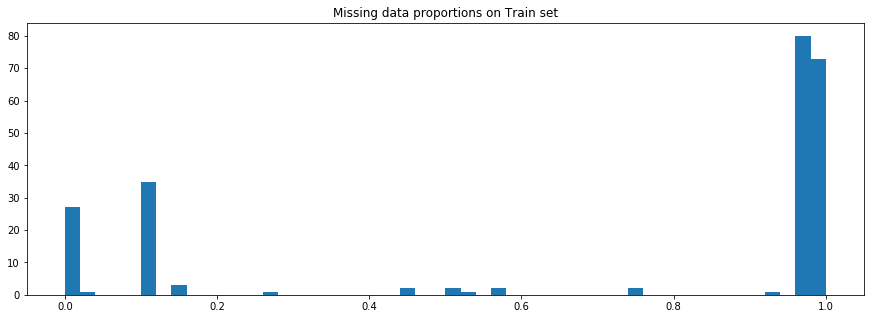

In [8]:
plot_missing_data(train)

I'll consider valid only features that have less than 15% missing data of its total data as our model features

In [9]:
train_missing = train.isnull().sum() / train.shape[0]
features = train_missing[train_missing <= 0.15].index

print(features)
print(len(features))

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76',
       'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113',
       'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140',
       'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173',
       'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198',
       'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227',
       'Var228'],
      dtype='object')
66


Filling the missing numeric values with respective column mean values

In [10]:
numeric_features = [feat for feat in features if train_types[feat] == float]

print(numeric_features)
print(len(numeric_features))

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181']
38


In [11]:
train[numeric_features] = train[numeric_features].fillna(
    train[numeric_features].mean()
)

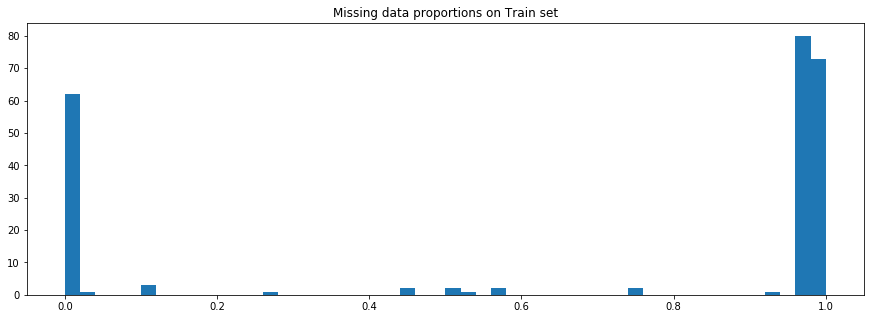

In [12]:
plot_missing_data(train)

I'll now remove the categorical features that have more than 400 categories in it

In [13]:
categorical_features = [feat for feat in features if train_types[feat] != float]

print(categorical_features)
print(len(categorical_features))

['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227', 'Var228']
28


In [14]:
categorical_levels = train[categorical_features].apply(lambda col: len(col.cat.categories))

categorical_features_filtered = categorical_levels[categorical_levels <= 400].index.tolist()
print(categorical_features_filtered)
print(len(categorical_features_filtered))

['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223', 'Var226', 'Var227', 'Var228']
21


In [15]:
features_filtered = numeric_features + categorical_features_filtered
print(features_filtered)
print(len(features_filtered))

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223', 'Var226', 'Var227', 'Var228']
59


In [16]:
train = train[features_filtered]
train = pd.get_dummies(train, dtype=bool)
train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var228__URKn_77G3QyQHSVQ2N1RKmtW,Var228__cTCyH95OE93jSkoIBT,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0
0,1526.000000,7.0,184.0,464.000000,580.0,14.000000,128.0,166.56,0.0,3570.0,...,False,False,False,False,False,False,False,False,False,False
1,525.000000,0.0,0.0,168.000000,210.0,2.000000,24.0,353.52,0.0,4764966.0,...,False,False,False,False,False,False,False,False,False,False
2,5236.000000,7.0,904.0,1212.000000,1515.0,26.000000,816.0,220.08,0.0,5883894.0,...,False,False,False,False,False,True,False,False,False,False
3,1326.437116,0.0,0.0,234.518225,0.0,4.507926,0.0,22.08,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,1029.000000,7.0,3216.0,64.000000,80.0,4.000000,64.0,200.00,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


## Train, Validation and Test split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    train, churn_label, test_size=0.2, random_state=RANDOM_SEED
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=RANDOM_SEED
)

In [18]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(32000, 1031)
(8000, 1031)
(10000, 1031)


## Model Training

### XGBoost Classifier

In [19]:
xgb = xgboost.XGBClassifier(
    n_jobs=8,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=2000,
    random_state=RANDOM_SEED,
)

In [20]:
xgb.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=True,
)

[0]	validation_0-auc:0.592133
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.592307
[2]	validation_0-auc:0.593291
[3]	validation_0-auc:0.592059
[4]	validation_0-auc:0.590834
[5]	validation_0-auc:0.590382
[6]	validation_0-auc:0.590445
[7]	validation_0-auc:0.59085
[8]	validation_0-auc:0.595243
[9]	validation_0-auc:0.592868
[10]	validation_0-auc:0.592713
[11]	validation_0-auc:0.592841
[12]	validation_0-auc:0.593998
[13]	validation_0-auc:0.594239
[14]	validation_0-auc:0.593643
[15]	validation_0-auc:0.594021
[16]	validation_0-auc:0.595786
[17]	validation_0-auc:0.596016
[18]	validation_0-auc:0.596069
[19]	validation_0-auc:0.597474
[20]	validation_0-auc:0.597336
[21]	validation_0-auc:0.597389
[22]	validation_0-auc:0.598089
[23]	validation_0-auc:0.597368
[24]	validation_0-auc:0.597843
[25]	validation_0-auc:0.597876
[26]	validation_0-auc:0.597843
[27]	validation_0-auc:0.597392
[28]	validation_0-auc:0.597894
[29]	validation_0-auc:0.598183
[30]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
              n_jobs=8, nthread=None, objective='binary:logistic',
              random_state=1212, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [21]:
y_score_xgb = xgb.predict_proba(x_test)

### GradientBoostingClassifier

In [22]:
gbc = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED,
    n_iter_no_change=10,
    verbose=1
)

In [23]:
gbc.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5251           18.92m
         2           0.5228           15.91m
         3           0.5207           14.67m
         4           0.5187           14.15m
         5           0.5170           13.76m
         6           0.5149           13.58m
         7           0.5133           13.30m
         8           0.5117           13.07m
         9           0.5099           12.88m
        10           0.5084           12.61m
        20           0.4938           11.35m
        30           0.4830            9.78m
        40           0.4734            8.32m
        50           0.4647            6.94m
        60           0.4560            5.52m
        70           0.4492            4.10m
        80           0.4427            2.79m
        90           0.4366            1.36m
       100           0.4317            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=10, presort='auto',
                           random_state=1212, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [24]:
y_score_gdb = gbc.predict_proba(x_test)

### RandomForestClassifier

In [25]:
rfc = RandomForestClassifier(
    n_estimators=2000, max_depth=10, n_jobs=8, random_state=RANDOM_SEED, verbose=1
)

In [26]:
rfc.fit(x_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   19.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   27.5s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   30.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=8, oob_score=False, random_state=1212, verbose=1,
                       warm_start=False)

In [27]:
y_score_rfc = rfc.predict_proba(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.7s finished


## AUC Comparison

In [28]:
def plot_roc_curve(y_true, y_score, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve for Churn class (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic for %s model" % model_name)
    plt.legend(loc="lower right")
    plt.show()

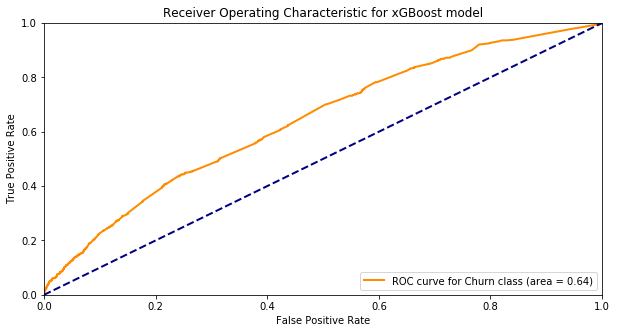

In [29]:
plot_roc_curve(y_test, y_score_xgb, "xGBoost")

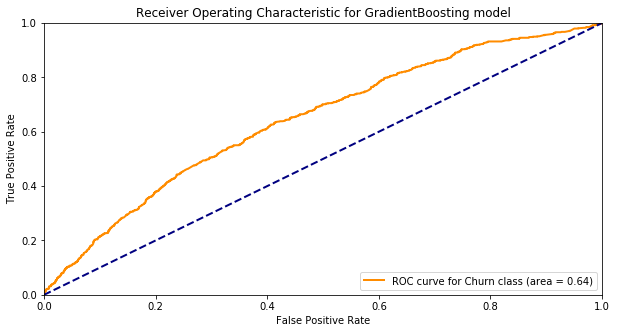

In [30]:
plot_roc_curve(y_test, y_score_gdb, "GradientBoosting")

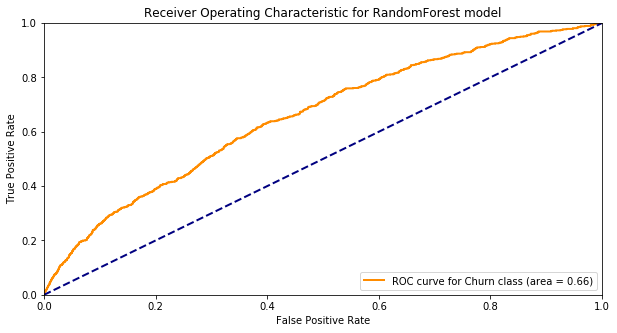

In [31]:
plot_roc_curve(y_test, y_score_rfc, "RandomForest")